In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import datetime

print(torch.cuda.is_available())

True


In [23]:
data_path = "./deep_learning/datasets/CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz"
split_lists = np.load('./deep_learning/sampling_folds/random_sampling_folds.npy', allow_pickle = True)
dataset = np.load(data_path)
data = dataset['data']

In [2]:
subset2col = {
	'flow+fund_mom+sentiment': list(range(56, 60))+[47],
	'fund_ex_mom_flow': [59]+ [x for x in range(46, 58) if x not in (list(range(54, 58))+[47])],
	'stock': range(46),
	'fund': range(46, 59),
	'fund+sentiment': range(46, 60),
	'stock+fund': range(59),
	'F_r12_2+sentiment': [58, 59],
	'stock+sentiment': [59]+list(range(0, 46)),
	'stock+fund+sentiment': range(60),
	'F_r12_2+flow+sentiment': [47, 58, 59]
}

def squeeze_data(data, UNK = -99.99):
	T, N, M = data.shape
	lists_considered = []    
	returns = data[:,:,0]    
	for i in range(N):      
		returns_i = returns[:,i]             
		if np.sum(returns_i!=UNK)>0:        
			lists_considered.append(i)         
	return data[:, lists_considered, :], lists_considered

class FirmChar:
	def __init__(self):
		self._category = ['Fund mom','Fund char', 'Fund Family', 'Sentiment']
		self._category2variables = {
			'Fund mom': ['F_ST_Rev', 'F_r2_1', 'F_r12_2'],
			'Fund char': ['ages', 'flow', 'exp_ratio', 'tna', 'turnover'],
			'Fund Family': ['Family_TNA', 'fund_no', 'Family_r12_2', 'Family_flow', 'Family_age'], 
			'Sentiment': ['sentiment', 'RecCFNAI', 'sentiment_lsq', 'sentiment_lad', 'CFNAI_orth', 'leading'], 
		}
		self._variable2category = {}
		for category in self._category:
			for var in self._category2variables[category]:
				self._variable2category[var] = category
		self._category2color = {
			'Fund mom': 'blue',
			'Fund char': 'plum',
			'Fund Family':'lime',
			'Sentiment':'darkgreen'
		}
		self._color2category = {value:key for key, value in self._category2color.items()}

	def getColorLabelMap(self):       
		return {var: self._category2color[self._variable2category[var]] for var in self._variable2category}


def get_data(data_path, split_list, subset):
	dataset = np.load(data_path)
	data = dataset['data']
	column_considered = [0]+[x+1 for x in subset2col[subset]]        
	data = data[:,:,column_considered]       
	data, list_considered = squeeze_data(data[split_list])
	return data, list_considered

def get_tensors(data, UNK = -99.99):
	ret = torch.tensor(data[:,:,0])
	individualFeature = torch.tensor(data[:,:,1:] )    
	macroFeature = torch.empty((data.shape[0], 0))
	mask = (ret != UNK)
	
	input_macro_tile = macroFeature.unsqueeze(1).repeat(1, ret.shape[1], 1)
	input_macro_masked = input_macro_tile[mask]
	input_masked = individualFeature[mask]
	input_concat = torch.concat([input_masked, input_macro_masked], dim=1)
	return_masked = ret[mask]
	
	return input_concat, return_masked, mask

def get_dataset(data_path, split_list, subset):
	datasets = []
	masks = []
	for split in split_list:
		data, list_considered = get_data(data_path, split, subset)
		input_concat, return_masked, mask = get_tensors(data)
		datasets.append(torch.utils.data.TensorDataset(input_concat, return_masked))
		masks.append(mask)
	return datasets, masks

def get_dataloader(datasets, batch_size, num_workers=4, shuffle=False):
	dataloaders = []
	for dataset in datasets:
		dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
		dataloaders.append(dataloader)
	return dataloaders

def get_crossval_dataloaders(data_path, split_lists, subset, batch_size, num_workers=4, shuffle=False):
	crossval_loaders = []
	masks = []
	for split_list in split_lists:	
		datasets, mask = get_dataset(data_path, split_list, subset)
		dataloaders = get_dataloader(datasets, batch_size, num_workers, shuffle)
		dict = {'datasets': datasets,
				'dataloaders': dataloaders}
		masks.append(mask)
		crossval_loaders.append(dict)
	return crossval_loaders, masks

def unload_data(dataloader):
	X_tensors = []
	y_tensors = []
	
	for i, (X, y) in enumerate(dataloader):
		X_tensors.append(X)
		y_tensors.append(y)
	
	return torch.cat(X_tensors, dim=0), torch.cat(y_tensors, dim=0)

def evaluate_sharpe(r_pred, r_masked, mask):
	# convert into numpy array
	if isinstance(r_pred, torch.Tensor):
		r_pred = r_pred.detach().cpu().numpy()
	if isinstance(r_masked, torch.Tensor):
		r_masked = r_masked.detach().cpu().numpy()
	if isinstance(mask, torch.Tensor):
		mask = mask.detach().cpu().numpy()
	portfolio = construct_long_short_portfolio(r_pred, r_masked, mask, low=0.1, high=0.1) # equally weighted
	return sharpe(portfolio)

def sharpe(r):
	return np.mean(r / r.std())

def construct_decile_portfolios(w, R, mask, value=None, decile=10):
	N_i = np.sum(mask.astype(int), axis=1)
	N_i_cumsum = np.cumsum(N_i)
	w_split = np.split(w, N_i_cumsum)[:-1]
	R_split = np.split(R, N_i_cumsum)[:-1]

	# value weighted
	value_weighted = False
	if value is not None:
		value_weighted = True
		value = value[mask]
		value_split = np.split(value, N_i_cumsum)[:-1]

	portfolio_returns = []

	for j in range(mask.shape[0]):
		R_j = R_split[j]
		w_j = w_split[j]
		if value_weighted:
			value_j = value_split[j]
			R_w_j = [(R_j[k], w_j[k], value_j[k]) for k in range(N_i[j])]
		else:
			R_w_j = [(R_j[k], w_j[k], 1) for k in range(N_i[j])]
		R_w_j_sorted = sorted(R_w_j, key=lambda t:t[1])
		n_decile = N_i[j] // decile
		R_decile = []
		for i in range(decile):
			R_decile_i = 0.0
			value_sum_i = 0.0
			for k in range(n_decile):
				R_decile_i += R_w_j_sorted[i*n_decile+k][0] * R_w_j_sorted[i*n_decile+k][2]
				value_sum_i += R_w_j_sorted[i*n_decile+k][2]
			R_decile.append(R_decile_i / value_sum_i)
		portfolio_returns.append(R_decile)
	return np.array(portfolio_returns)

def construct_long_short_portfolio(w, R, mask, value=None, low=0.1, high=0.1, normalize=True):
	# use masked R and value
	N_i = np.sum(mask.astype(int), axis=1)
	N_i_cumsum = np.cumsum(N_i)
	w_split = np.split(w, N_i_cumsum)[:-1]
	R_split = np.split(R, N_i_cumsum)[:-1]

	# value weighted
	value_weighted = False
	if value is not None:
		value_weighted = True
		value_split = np.split(value, N_i_cumsum)[:-1]

	portfolio_returns = []

	for j in range(mask.shape[0]):
		R_j = R_split[j]
		w_j = w_split[j]
		if value_weighted:
			value_j = value_split[j]
			R_w_j = [(R_j[k], w_j[k], value_j[k]) for k in range(N_i[j])]
		else:
			R_w_j = [(R_j[k], w_j[k], 1) for k in range(N_i[j])]
		R_w_j_sorted = sorted(R_w_j, key=lambda t:t[1])
		n_low = int(low * N_i[j])
		n_high = int(high * N_i[j])

		if n_high == 0.0:
			portfolio_return_high = 0.0
		else:
			portfolio_return_high = 0.0
			value_sum_high = 0.0
			for k in range(n_high):
				portfolio_return_high += R_w_j_sorted[-k-1][0] * R_w_j_sorted[-k-1][2]
				value_sum_high += R_w_j_sorted[-k-1][2]
			if normalize:
				portfolio_return_high /= value_sum_high

		if n_low == 0:
			portfolio_return_low = 0.0
		else:
			portfolio_return_low = 0.0
			value_sum_low = 0.0
			for k in range(n_low):
				portfolio_return_low += R_w_j_sorted[k][0] * R_w_j_sorted[k][2]
				value_sum_low += R_w_j_sorted[k][2]
			if normalize:
				portfolio_return_low /= value_sum_low
		if np.isnan(portfolio_return_high) or np.isnan(portfolio_return_low) or np.isinf(portfolio_return_high) or np.isinf(portfolio_return_low):
			print (portfolio_return_high)
			print (portfolio_return_low)                 

		portfolio_returns.append(portfolio_return_high - portfolio_return_low)
	return np.array(portfolio_returns)

In [3]:
class Deep_Network(torch.nn.Module):
	'''
	The module class performs building network according to config
    '''
	def __init__(self, config):
		super(Deep_Network, self).__init__()
		# parses parameters of network from configuration
		self.dropout = config['dropout']
		self.num_layers = config['num_layers']
		self.hidden_dim = config['hidden_dim']
		self.input_dim = config['input_dim']
		
        # builds network
		self.hidden_layers = torch.nn.ModuleList()
		for i in range(self.num_layers):
			input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]
			self.hidden_layers.append(torch.nn.Linear(input_dim, self.hidden_dim[i]))
		
		if self.dropout > 0:
			self.dropout_layer = torch.nn.Dropout(self.dropout)
		self.output_layer = torch.nn.Linear(self.hidden_dim[-1], 1)
	
	def forward(self, X):
		for layer in self.hidden_layers:
			X = layer(X)
			X = torch.nn.functional.relu(X)
			if self.dropout > 0:
				X = self.dropout_layer(X)
		return self.output_layer(X).squeeze(-1)

In [4]:
config = {
	'data_path': "./deep_learning/datasets/CharAll_na_rm_huge_train_variableall4_sentiment_full_new.npz",
	'split_lists_path': './deep_learning/sampling_folds/random_sampling_folds.npy',
	'subset': 'fund+sentiment',
	'num_layers': 1,
	'hidden_dim': [2**6],
	'dropout': 0.,
	'learning_rate': 0.001,
	'epochs': 512,
	'weighted_loss': False,
	'reg_l1': 0.0,
	'reg_l2': 0.001,
	'batch_size': 300000,
	'criteria': 'Factor_sharpe',
	'ensemble_members': 8,
	'random_seed': 15,
	'device': 'cuda' if torch.cuda.is_available() else 'cpu',
	'num_workers': 4
}

config['split_lists'] = np.load(config['split_lists_path'], allow_pickle = True)
config['input_dim'] = len(subset2col[config['subset']])

In [59]:
model = Deep_Network(config).to(device=config['device'])
print(model)

Deep_Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=14, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [41]:
crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], 'fund+sentiment', batch_size=config['batch_size'])

for i in range(len(crossval_loaders)):
	print('Cross-validation fold {}'.format(i+1))
	for j in crossval_loaders[i]['datasets']:
		print(len(j))
	print('')

Cross-validation fold 1
208161
68181
130816

Cross-validation fold 2
198258
68181
140719

Cross-validation fold 3
208191
63344
135623



In [42]:
fold = 0
train, val, test = crossval_loaders[fold]['datasets']
train_loader, val_loader, test_loader = crossval_loaders[fold]['dataloaders']
train_mask, val_mask, test_mask = masks[fold]

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['reg_l2'])
criterion = torch.nn.MSELoss()

best_model_state = model.state_dict()
best_val_loss = torch.tensor(float('inf'))
best_val_sharpe = torch.tensor(-float('inf'))
sharpe_train = []
sharpe_val = []
loss_train = []
loss_val = []

run = 0
time_start = time.time()
for epoch in range(config['epochs']):
	epoch_loss = torch.tensor(0.0)
	y_train = []
	y_pred_train = []
	for i, (X, y) in enumerate(train_loader):
		X, y = X.float().to(config['device']), y.float().to(config['device'])
		optimizer.zero_grad()
		y_pred = model(X)
		
		loss = criterion(y_pred, y)	
		loss.backward()
		optimizer.step()	
		epoch_loss += loss.detach().cpu().item()
		
		y_train.append(y.detach().cpu())
		y_pred_train.append(y_pred.detach().cpu())
		
	epoch_loss /= i + 1
	y_train = torch.cat(y_train, dim=0)
	y_pred_train = torch.cat(y_pred_train, dim=0)
	
	sharpe_train_value = evaluate_sharpe(y_pred_train, y_train, train_mask)
	epoch_sharpe = sharpe_train_value
	sharpe_train.append(epoch_sharpe)
	loss_train.append(epoch_loss)
	
	# Validation
	with torch.no_grad():
		epoch_val_loss = torch.tensor(0.0)
		y_val = []
		y_pred_val = []
		for i, (X, y) in enumerate(val_loader):
			X, y = X.float().to(config['device']), y.float().to(config['device'])
			y_pred = model(X)
			loss = criterion(y_pred, y)
			epoch_val_loss += loss.detach().cpu().item()
			
			y_val.append(y.detach().cpu())
			y_pred_val.append(y_pred.detach().cpu())
			
	epoch_val_loss /= i + 1
	y_val = torch.cat(y_val, dim=0)
	y_pred_val = torch.cat(y_pred_val, dim=0)
	
	sharpe_val_value = evaluate_sharpe(y_pred_val, y_val, val_mask)
	epoch_val_sharpe = sharpe_val_value
	sharpe_val.append(epoch_val_sharpe)
	loss_val.append(epoch_val_loss)
	
	if epoch <= 50 or epoch % 10 == 0:
		print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))
	
	if config['criteria'] == 'Factor_sharpe':
		if epoch_val_sharpe > best_val_sharpe:
			best_val_sharpe = epoch_val_sharpe
			best_model_state = model.state_dict()
			print("Best model updated at epoch {}".format(epoch+1))
			if epoch > 50 and epoch % 10 != 0:
				print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))
	
	elif epoch_val_loss < best_val_loss:
		best_val_loss = epoch_val_loss
		best_model_state = model.state_dict()
		print("Best model updated at epoch {}".format(epoch+1))
		if epoch > 50 and epoch % 10 != 0:
			print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))

exp_path = './Experiments/'
exp_subset_path = os.path.join(exp_path, config['subset'])
if not os.path.exists(exp_subset_path):
	os.makedirs(exp_subset_path)

model.load_state_dict(best_model_state)
time_stamp = datetime.datetime.today().strftime('%Y%m%d_%H%M')
model_save_path = os.path.join(exp_subset_path, 'fold' + str(fold+1) + '_' + 'model' + str(run) + '_' + config['subset'] + '_' + time_stamp + '.pth')
torch.save(model, model_save_path)

duration = time.time() - time_start
print('Training completed in {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))

Epoch 1 - Training Loss: 0.02872809, Val Loss: 0.02857450, Train Sharpe: 0.18978538, Validation Sharpe: -0.00351208
Best model updated at epoch 1
Epoch 2 - Training Loss: 0.02539634, Val Loss: 0.02517699, Train Sharpe: 0.18991265, Validation Sharpe: 0.00241252
Best model updated at epoch 2
Epoch 3 - Training Loss: 0.02231650, Val Loss: 0.02205317, Train Sharpe: 0.17910929, Validation Sharpe: -0.02640941
Epoch 4 - Training Loss: 0.01948923, Val Loss: 0.01920264, Train Sharpe: 0.16443709, Validation Sharpe: 0.01476136
Best model updated at epoch 4
Epoch 5 - Training Loss: 0.01691399, Val Loss: 0.01662318, Train Sharpe: 0.15174508, Validation Sharpe: 0.02448581
Best model updated at epoch 5
Epoch 6 - Training Loss: 0.01458881, Val Loss: 0.01431057, Train Sharpe: 0.14126463, Validation Sharpe: 0.03273516
Best model updated at epoch 6
Epoch 7 - Training Loss: 0.01250974, Val Loss: 0.01225867, Train Sharpe: 0.12613229, Validation Sharpe: 0.01536841
Epoch 8 - Training Loss: 0.01067082, Val Lo

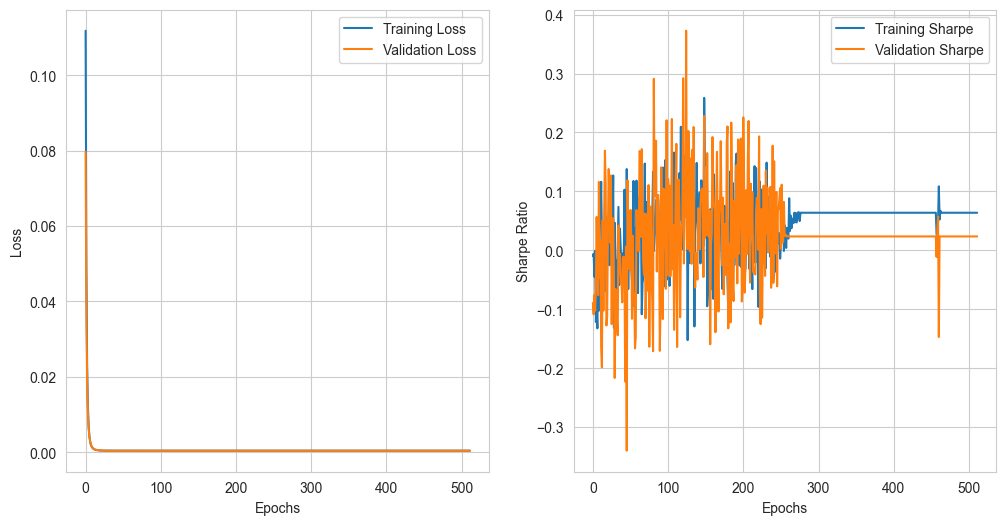

In [31]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_train, label='Training Loss')
plt.plot(loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sharpe_train, label='Training Sharpe')
plt.plot(sharpe_val, label='Validation Sharpe')
plt.xlabel('Epochs')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

In [5]:
def train_one_epoch(model, train_loader, mask, optimizer, criterion, config):
	epoch_loss = torch.tensor(0.0)
	y_train = []
	y_pred_train = []
	
	for i, (X, y) in enumerate(train_loader):
		X, y = X.float().to(config['device']), y.float().to(config['device'])
		optimizer.zero_grad()
		y_pred = model(X)
		
		loss = criterion(y_pred, y)	
		loss.backward()
		optimizer.step()	
		epoch_loss += loss.detach().cpu().item()
		
		y_train.append(y.detach().cpu())
		y_pred_train.append(y_pred.detach().cpu())
	
	epoch_loss /= i + 1
	y_train = torch.cat(y_train, dim=0)
	y_pred_train = torch.cat(y_pred_train, dim=0)
	epoch_sharpe = evaluate_sharpe(y_pred_train, y_train, mask)
	
	return epoch_loss, epoch_sharpe

def validate(model, val_loader, mask, criterion, config):
	# Validation
	with torch.no_grad():
		epoch_val_loss = torch.tensor(0.0)
		y_val = []
		y_pred_val = []
		for i, (X, y) in enumerate(val_loader):
			X, y = X.float().to(config['device']), y.float().to(config['device'])
			y_pred = model(X)
			
			loss = criterion(y_pred, y)
			epoch_val_loss += loss.detach().cpu().item()
			y_val.append(y.detach().cpu())
			y_pred_val.append(y_pred.detach().cpu())
			
	epoch_val_loss /= i + 1
	y_val = torch.cat(y_val, dim=0)
	y_pred_val = torch.cat(y_pred_val, dim=0)
	epoch_val_sharpe = evaluate_sharpe(y_pred_val, y_val, mask)
	
	return epoch_val_loss, epoch_val_sharpe

def training(model, train_loader, val_loader, train_mask, val_mask, config, fold, run):
	optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['reg_l2'])
	criterion = torch.nn.MSELoss()
	best_model_state = model.state_dict()
	best_val_loss = torch.tensor(float('inf'))
	best_val_sharpe = torch.tensor(-float('inf'))
	best_epoch = 0
	
	sharpe_train = []
	sharpe_val = []
	loss_train = []
	loss_val = []
	
	time_start = time.time()
	for epoch in range(config['epochs']):
		epoch_loss, epoch_sharpe = train_one_epoch(model=model,
												   train_loader=train_loader,
												   mask=train_mask,
												   optimizer=optimizer, 
												   criterion=criterion,
												   config=config)
		loss_train.append(epoch_loss)
		sharpe_train.append(epoch_sharpe)
		
		# Validation
		epoch_val_loss, epoch_val_sharpe = validate(model=model,
													val_loader=val_loader,
													mask=val_mask,
													criterion=criterion,
													config=config)
		loss_val.append(epoch_val_loss)
		sharpe_val.append(epoch_val_sharpe)
		
		if epoch <= 50 or epoch % 50 == 0:
			print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1,
																															   epoch_loss,
																															   epoch_val_loss,
																															   epoch_sharpe,
																															   epoch_val_sharpe))

		if config['criteria'] == 'Factor_sharpe':
			if epoch_val_sharpe > best_val_sharpe:
				best_val_sharpe = epoch_val_sharpe
				best_model_state = model.state_dict()
				best_epoch = epoch
				print("Best model updated at epoch {}".format(epoch+1))
				if epoch > 50 and epoch % 50 != 0:
					print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))
		
		elif epoch_val_loss < best_val_loss:
			best_val_loss = epoch_val_loss
			best_model_state = model.state_dict()
			best_epoch = epoch
			print("Best model updated at epoch {}".format(epoch+1))
			if epoch > 50 and epoch % 10 != 0:
				print('Epoch {} - Training Loss: {:.8f}, Val Loss: {:.8f}, Train Sharpe: {:.8f}, Validation Sharpe: {:.8f}'.format(epoch+1, epoch_loss, epoch_val_loss, epoch_sharpe, epoch_val_sharpe))
	
	exp_path = './Experiments/'
	exp_subset_path = os.path.join(exp_path, config['subset'])
	if not os.path.exists(exp_subset_path):
		os.makedirs(exp_subset_path)
	
	exp_subset_fold_path = os.path.join(exp_subset_path, 'fold' + str(fold+1))
	if not os.path.exists(exp_subset_fold_path):
		os.makedirs(exp_subset_fold_path)
	
	model.load_state_dict(best_model_state)
	time_stamp = datetime.datetime.today().strftime('%Y%m%d_%H%M')
	model_save_path = os.path.join(exp_subset_fold_path, 'fold' + str(fold+1) + '_' + 'model' + str(run+1) + '_' + config['subset'] + '_' + time_stamp + '.pth')
	torch.save(model, model_save_path)
	
	duration = time.time() - time_start
	print('Training completed in {:.0f}m {:.0f}s'.format(duration // 60, duration % 60))
	return model, loss_train, loss_val, sharpe_train, sharpe_val, best_epoch

In [ ]:
ensemble_members = 8
fold = 0

crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])
train, val, test = crossval_loaders[fold]['datasets']
train_loader, val_loader, test_loader = crossval_loaders[fold]['dataloaders']
train_mask, val_mask, test_mask = masks[fold]

avg_loss = {'train': 0.0, 'val': 0.0, 'test': 0.0}
avg_sharpe = {'train': 0.0, 'val': 0.0, 'test': 0.0}

for run in range(ensemble_members):
	print('Running ensemble member no. {}'.format(run+1))
	model = Deep_Network(config).to(device=config['device'])
	model, loss_train, loss_val, sharpe_train, sharpe_val, best_epoch = training(model, train_loader, val_loader, train_mask, val_mask, config, fold, run)
	test_loss, test_sharpe = validate(model, test_loader, test_mask, torch.nn.MSELoss(), config)
	
	avg_loss['train'] += loss_train[best_epoch]
	avg_loss['val'] += loss_val[best_epoch]
	avg_loss['test'] += test_loss
	
	avg_sharpe['train'] += sharpe_train[best_epoch]
	avg_sharpe['val'] += sharpe_val[best_epoch]
	avg_sharpe['test'] += test_sharpe

avg_loss = {key: value / (run+1) for key, value in avg_loss.items()}
avg_sharpe = {key: value / (run+1) for key, value in avg_sharpe.items()}

In [6]:
def train_ensembles(config, crossval_loaders, masks, fold, ensemble_members=8):
	train_loader, val_loader, test_loader = crossval_loaders[fold]['dataloaders']
	train_mask, val_mask, test_mask = masks[fold]
	
	avg_loss_ens = {'train': 0.0, 'val': 0.0, 'test': 0.0}
	avg_sharpe_ens = {'train': 0.0, 'val': 0.0, 'test': 0.0}
	
	for run in range(ensemble_members):
		print('\nTRAINING ENSEMBLE MEMBER {}'.format(run+1))
		model = Deep_Network(config).to(device=config['device'])
		model, loss_train, loss_val, sharpe_train, sharpe_val, best_epoch = training(model, train_loader, val_loader, train_mask, val_mask, config, fold, run)
		test_loss, test_sharpe = validate(model, test_loader, test_mask, torch.nn.MSELoss(), config)
		
		avg_loss_ens['train'] += loss_train[best_epoch]
		avg_loss_ens['val'] += loss_val[best_epoch]
		avg_loss_ens['test'] += test_loss
		
		avg_sharpe_ens['train'] += sharpe_train[best_epoch]
		avg_sharpe_ens['val'] += sharpe_val[best_epoch]
		avg_sharpe_ens['test'] += test_sharpe
	
	avg_loss_ens = {key: value / (ensemble_members) for key, value in avg_loss_ens.items()}
	avg_sharpe_ens = {key: value / (ensemble_members) for key, value in avg_sharpe_ens.items()}
	
	return avg_loss_ens, avg_sharpe_ens

In [ ]:
crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])

avg_loss_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}
avg_sharpe_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}

for fold in range(len(crossval_loaders)):
	print('\nRUNNING FOLD NO. {}'.format(fold+1))
	avg_loss_ens, avg_sharpe_ens = train_ensembles(config, crossval_loaders, masks, fold, config['ensemble_members'])
	
	avg_loss_fold['train'] += avg_loss_ens['train']
	avg_loss_fold['val'] += avg_loss_ens['val']
	avg_loss_fold['test'] += avg_loss_ens['test']
	
	avg_sharpe_fold['train'] += avg_sharpe_ens['train']
	avg_sharpe_fold['val'] += avg_sharpe_ens['val']
	avg_sharpe_fold['test'] += avg_sharpe_ens['test']

avg_loss_fold = {key: value / (len(crossval_loaders)) for key, value in avg_loss_fold.items()}
avg_sharpe_fold = {key: value / (len(crossval_loaders)) for key, value in avg_sharpe_fold.items()}

print(avg_loss_fold)
print(avg_sharpe_fold)


RUNNING FOLD NO. 1

TRAINING ENSEMBLE MEMBER 1
Epoch 1 - Training Loss: 0.00719792, Val Loss: 0.00672514, Train Sharpe: -0.17059104, Validation Sharpe: -0.16196084
Best model updated at epoch 1
Epoch 2 - Training Loss: 0.00589450, Val Loss: 0.00551381, Train Sharpe: -0.16686632, Validation Sharpe: -0.20798695
Epoch 3 - Training Loss: 0.00486706, Val Loss: 0.00459242, Train Sharpe: -0.16529635, Validation Sharpe: -0.20762973
Epoch 4 - Training Loss: 0.00410437, Val Loss: 0.00393244, Train Sharpe: -0.17694706, Validation Sharpe: -0.20383722
Epoch 5 - Training Loss: 0.00357805, Val Loss: 0.00348807, Train Sharpe: -0.17902026, Validation Sharpe: -0.17700179
Epoch 6 - Training Loss: 0.00324291, Val Loss: 0.00319936, Train Sharpe: -0.17015506, Validation Sharpe: -0.17527135
Epoch 7 - Training Loss: 0.00304036, Val Loss: 0.00300372, Train Sharpe: -0.17288339, Validation Sharpe: -0.09014613
Best model updated at epoch 7
Epoch 8 - Training Loss: 0.00291008, Val Loss: 0.00284890, Train Sharpe: 

In [15]:
class Deep_Ensemble():
	def __init__(self, config, model_dirs):
		self._model_dirs = model_dirs
		self._model = Deep_Network(config).to(device=config['device'])
	
	def predict(self, data):
		ensemble_predictions = []
		for model_file in os.listdir(self._model_dirs):
			model_path = os.path.join(self._model_dirs, model_file)
			if os.path.isfile(model_path) and model_file.endswith('.pth'):
				self._model.load_state_dict(torch.load(model_path, weights_only=False).state_dict())
				self._model.eval()
				with torch.no_grad():
					y_pred = self._model(data)
					ensemble_predictions.append(y_pred)
		#returns the average of the ensemble predictions
		return torch.mean(torch.stack(ensemble_predictions), dim=0)

In [16]:
avg_sharpe_fold_ens = 0.
for fold in range(len(crossval_loaders)):
	model_dirs = os.path.join('./Experiments/', config['subset'], 'fold' + str(fold+1))
	ensemble = Deep_Ensemble(config, model_dirs)
	
	crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])
	_, _, test_loader = crossval_loaders[fold]['dataloaders']
	X_test, y_test = unload_data(test_loader)
	_, _, test_mask = masks[fold]
	
	ens_pred_test = ensemble.predict(X_test.float().to(config['device']))
	sharpe_test = evaluate_sharpe(ens_pred_test, y_test, test_mask)
	print(sharpe_test)
	avg_sharpe_fold_ens += sharpe_test

avg_sharpe_fold_ens /= len(crossval_loaders)
print(avg_sharpe_fold_ens)

-0.32411616676669497
0.16614131398356732
-0.14898776745329467
-0.10232087341214076


In [ ]:
def run_one_subset(config):
	crossval_loaders, masks = get_crossval_dataloaders(config['data_path'], config['split_lists'], config['subset'], batch_size=config['batch_size'])

	avg_loss_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}
	avg_sharpe_fold = {'train': 0.0, 'val': 0.0, 'test': 0.0}
	
	for fold in range(len(crossval_loaders)):
		print('Running fold no. {}'.format(fold+1))
		avg_loss_ens, avg_sharpe_ens = train_ensembles(config, crossval_loaders, masks, fold, config['ensemble_members'])
		
		avg_loss_fold['train'] += avg_loss_ens['train']
		avg_loss_fold['val'] += avg_loss_ens['val']
		avg_loss_fold['test'] += avg_loss_ens['test']
		
		avg_sharpe_fold['train'] += avg_sharpe_ens['train']
		avg_sharpe_fold['val'] += avg_sharpe_ens['val']
		avg_sharpe_fold['test'] += avg_sharpe_ens['test']
	
	avg_loss_fold = {key: value / (len(crossval_loaders)) for key, value in avg_loss_fold.items()}
	avg_sharpe_fold = {key: value / (len(crossval_loaders)) for key, value in avg_sharpe_fold.items()}
	return avg_loss_fold, avg_sharpe_fold

def run_all_subsets(config):
	losses = {}
	sharpes = {}
	for subset in subset2col.keys():
		config['subset'] = subset
		config['input_dim'] = len(subset2col[config['subset']])
		losses[subset], sharpes[subset] = run_one_subset(config)
	return losses, sharpes

In [ ]:
if __name__ == "__main__":
	losses, sharpes = run_all_subsets(config)
	print(losses)
	print(sharpes)